# Unsupervised Machine Learning - Final Project

### Creating Clusters of Need For Countries in the HELP International Database

In [1]:
#import packages
#data manipulation and visuals packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib
import warnings
import itertools
from pylab import rcParams

import skillsnetwork
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#ML associated packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

### Description of dataset
The dataset used has 10 variables:
* Country: Name of country
* Child MOrtality: Death of children under 5 years of age per 1000 live births
* Exports: Exports of goods and services per capita. Given as %age of the GDP per capita
* Health: Total health spending per capita. Given as %age of GDP per capita
* Imports: Imports of goods and services per capita. Given as %age of the GDP per capita
* Income: Net income per person
* Inflation: The measurement of the annual growth rate of the Total GDP
* Life Expectancy: The average number of years a new born child would live if the current mortality patterns are to remain the same
* Total Fertility: The number of children that would be born to each woman if the current age-fertility rates remain the same
* GDPP: The GDP per capita. Calculated as the Total GDP divided by the total population

### About HELP International
* Mission: Established in 1999, the mission of HELP International is to fight poverty and empower people. HELP does this by connecting individual donors and companies to the most urgent issues facing global communities today and by creating sustainable, life-changing development programs for you to go to the field and work with us directly.

* Goals: HELP Internationl's unique model allows individuals to contribute directly to the most urgent global needs by either:
1. donating directly to our carefully evaluated projects and programs, catalyzing the efforts of our local partners on the ground as we work together to co-create change or
2. by choosing to participate yourself and volunteer in-country with us, creating and over-seeing projects with a team to alleviate poverty

### Problem Statement (sourced from Dataset)

HELP International have been able to raise around 10 million dollars. Now the CEO of the NGO needs to decide how to use this money strategically and effectively.

So, the CEO has to make decision to choose the countries that are in the direst need of aid.

Hence, the goal is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

In [2]:
#load dataset and preview
path = "/Users/duanemadziva/Documents/Documents - Duane’s MacBook Pro/_ Print (Hello World)/Learning Python/PythonVS/Certifications/IBM Machine Learning/"
data = pd.read_csv(path+'HELP Foundation.csv')
data_dictionary = pd.read_csv(path+'HELP Foundation Data Dictionary.csv')

pd.set_option('display.max_columns', None)
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
#Print data dictionary
print(data_dictionary)

  Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...


In [4]:
#Find missing values across all columns
data.isnull().sum() #there are no missing values

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [5]:
#Given all variables are continous with the exception of country, we will look into the distribution of values
data.describe().applymap(lambda x: f"{x:0.2f}")

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,41.11,6.82,46.89,17144.69,7.78,70.56,2.95,12964.16
std,40.33,27.41,2.75,24.21,19278.07,10.57,8.89,1.51,18328.70
min,2.60,0.11,1.81,0.07,609.00,-4.21,32.10,1.15,231.00
25%,8.25,23.80,4.92,30.20,3355.00,1.81,65.30,1.79,1330.00
50%,19.30,35.00,6.32,43.30,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,51.35,8.60,58.75,22800.00,10.75,76.80,3.88,14050.00
max,208.00,200.00,17.90,174.00,125000.00,104.00,82.80,7.49,105000.00


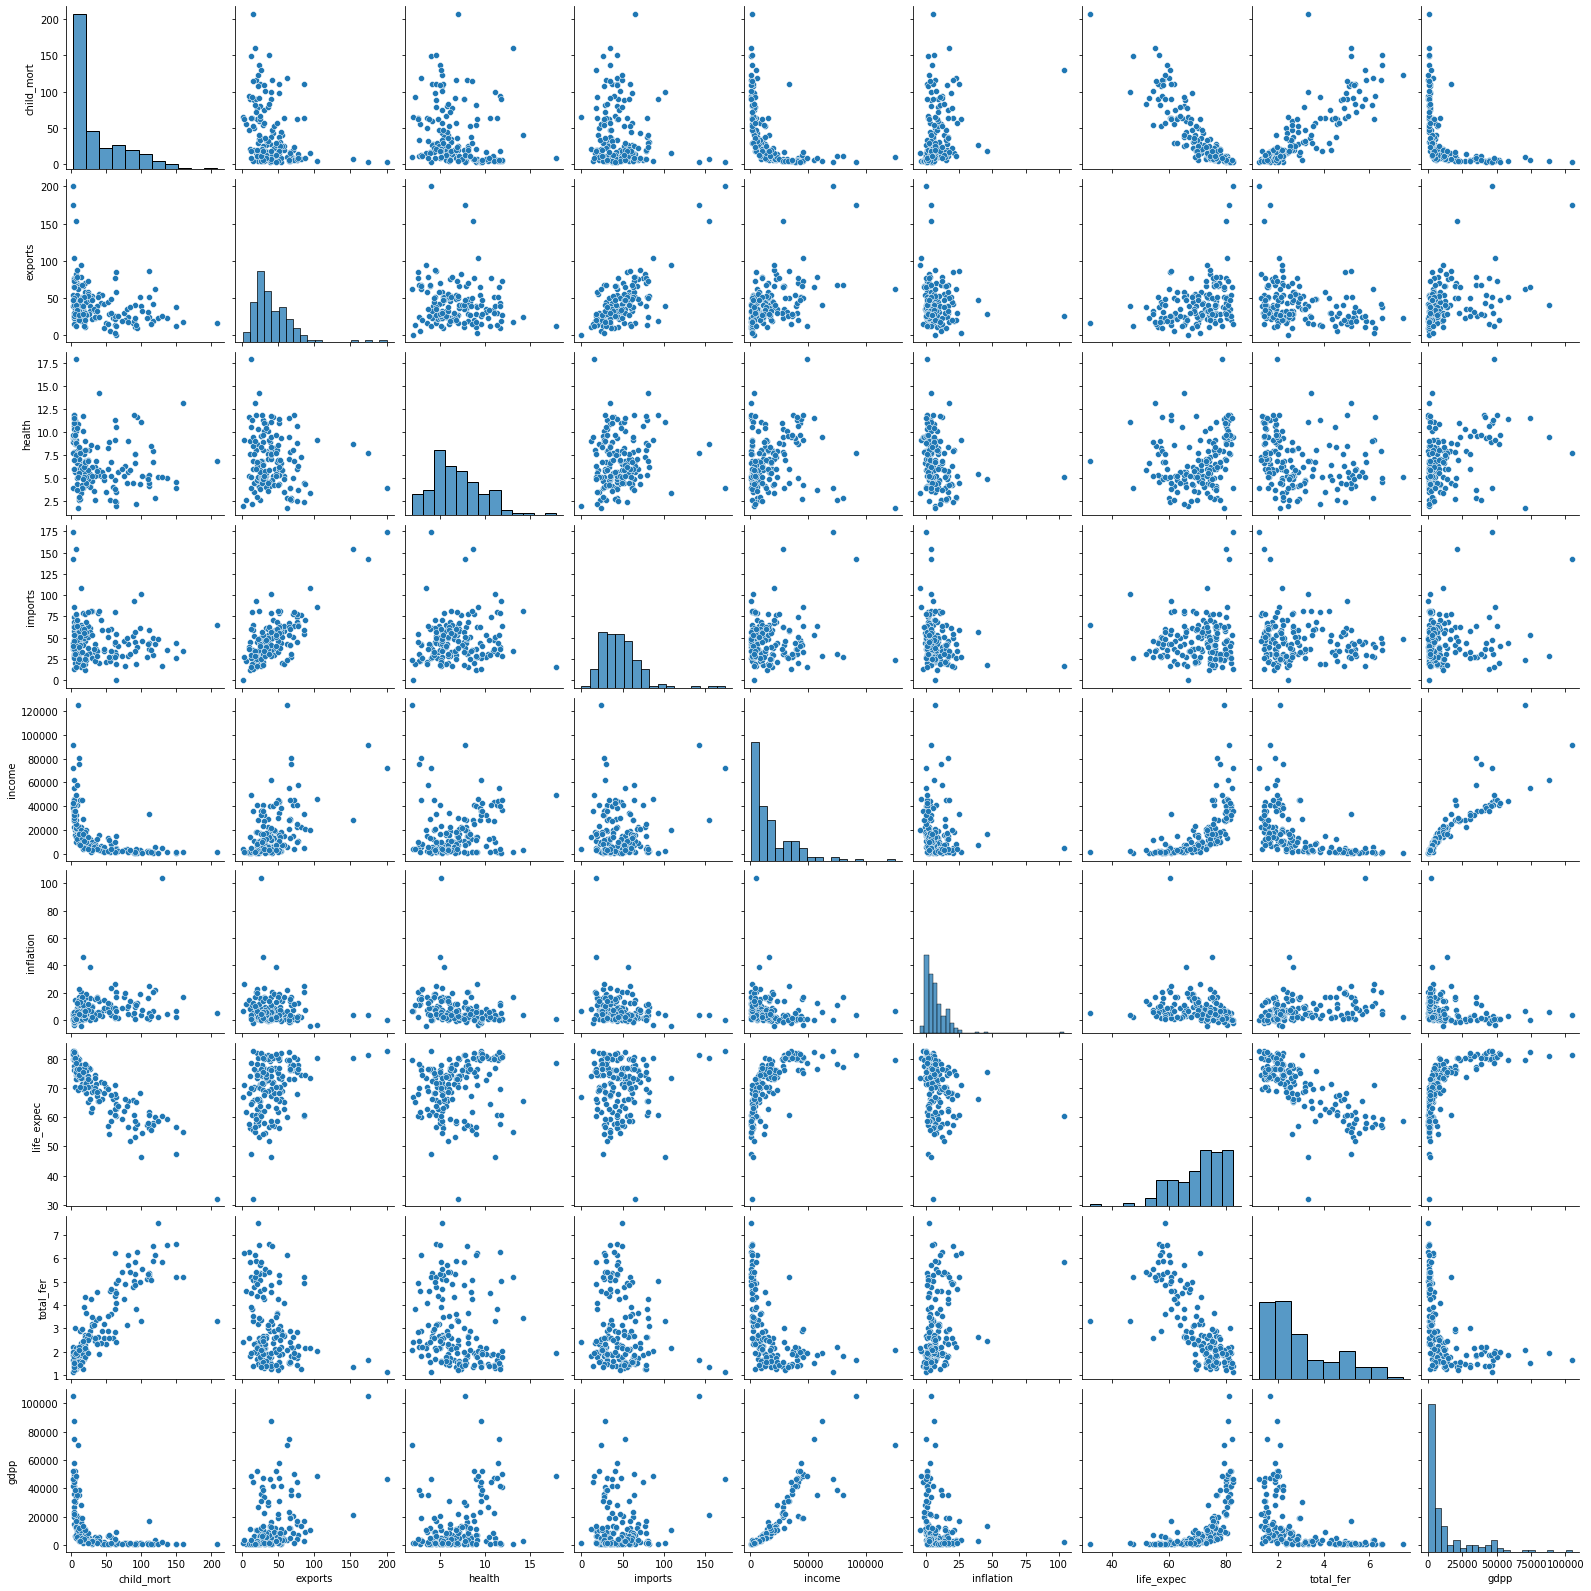

In [6]:
#find visual distribution of variables and their relationships
sns.pairplot(data.loc[:, 'child_mort': 'gdpp']);

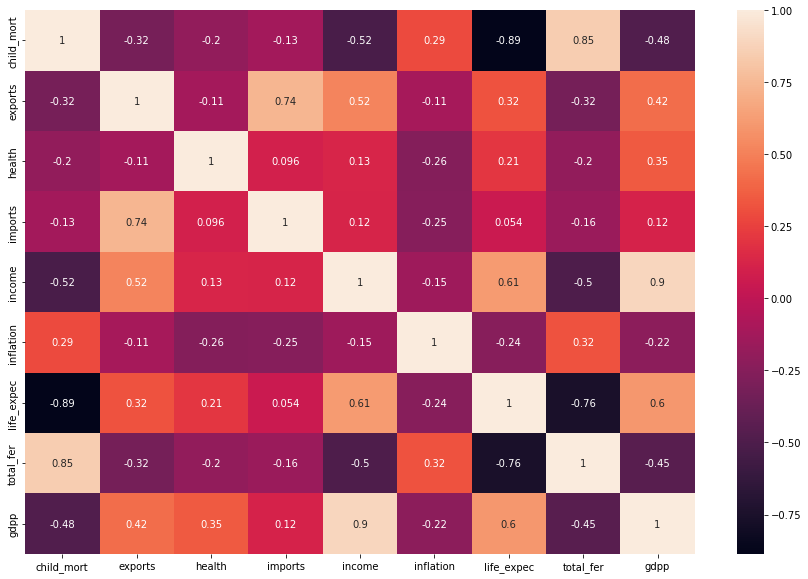

In [7]:
#find correlation of variables, except for country
#Pearson's Correlation
plt.figure(figsize=(15,10))
sns.heatmap(data.loc[:, 'child_mort': 'gdpp'].corr(method='pearson', min_periods=1),annot=True);

### Insights from the Correlation and Pairplots
* We can see that there is very high absolute correlation between:
    * Total fertility and child mortality (0.85)
    * GDPP and income (0.9)
    * Child mortality and life expectency (0.89)

Which prompts us to believe that, some of the above variables can be removed to reduce dimensionality and potentially improve the perfomance of our unsupervised clusterng methods. As such, we will conduct PCA to remove variables that minimally explain the variance in the dataset.

In order to conduct PCA, we need to scale our features, and we can make use of both MinMax and Standard Scalers.

In [8]:
features_df = data.loc[:, 'child_mort': 'gdpp']

#MInitiate scalers
mm_scaler = MinMaxScaler()
s_scaler = StandardScaler()

#scaled features
mm_features = mm_scaler.fit_transform(features_df)
ss_features = s_scaler.fit_transform(features_df)

#outputs are arrays, lets cnvert them to dataframes
mm_features_df = pd.DataFrame(data = mm_features, columns = features_df.columns)
ss_features_df = pd.DataFrame(data = ss_features, columns = features_df.columns)

In [9]:
mm_features_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


### Conducting PCA (Principal Component Analysis)

In [10]:
#conduct PCA analysis
def principal_component_analysis_assessment(df):
    pca = PCA()
    pca.fit(df)

    pca_data = pca.transform(df)
    percent_variation =  np.round(pca.explained_variance_ratio_*100, decimals =1)
    pc_x = ['PC' + str(x) for x in range (1, len(percent_variation)+1)]

    return pd.concat([pd.DataFrame(pc_x, columns = ['Principal Component']), pd.DataFrame(percent_variation, columns = ['Percent Variation (%)'])], axis = 1)

In [11]:
#PCA on MinMax Scaled data
principal_component_analysis_assessment(mm_features_df)

,Principal Component,Percent Variation (%)
0,PC1,55.0
1,PC2,13.4
2,PC3,12.3
3,PC4,9.7
4,PC5,3.8
5,PC6,3.0
6,PC7,1.2
7,PC8,0.9
8,PC9,0.7


In [12]:
#PCA on Standard Scaled data
principal_component_analysis_assessment(ss_features_df)

,Principal Component,Percent Variation (%)
0,PC1,46.0
1,PC2,17.2
2,PC3,13.0
3,PC4,11.1
4,PC5,7.3
5,PC6,2.5
6,PC7,1.3
7,PC8,1.0
8,PC9,0.7


In [13]:
#Create function that extracts the first 4 components from PCA
def principal_component_analysis_PC4(df):
    pca = PCA()
    pca.fit(df)

    pca_data = pca.transform(df)
    percent_variation =  np.round(pca.explained_variance_ratio_*100, decimals =1)
    pc_x = ['PC' + str(x) for x in range (1, len(percent_variation)+1)]

    pca_data = pd.DataFrame(pca_data, columns = pc_x)
    

    return pca_data[['PC1', 'PC2', 'PC3', 'PC4']]

As we can see from the PCA for both forms of scaled data, the first 4 principal components explain over 87% of the data. As such, we will use 4 datasets when we initiate our clustering algorithms:
* Min Max Scaled Data
    * PCA transformed data with the first 4 principal components
* Standard Scaled Data
    * PCA transformed data with the first 4 principal components

3 Clustering algorithms to be used:
* K-Means Clustering
* Hierrachichal Agglomerative Clustering
* DBSCAN

In order to simplify our the number of clusters required, we will make use of World Bank and WHO definitions of regional classificaitons, which are Low-, Moderate- and High need countries (as defined using low-, middle- and high-income countries), which will require our clustering algorithms to have 3 clusters.

### K-Means Clustering

In [14]:
def kmeans_clustering(df):
    km = KMeans(n_clusters = 3)

    return km.fit_predict(df)

km_mm_features_clusters = kmeans_clustering(mm_features_df)
km_mm_features_pc4_clusters = kmeans_clustering(principal_component_analysis_PC4(mm_features_df))
km_ss_features_clusters = kmeans_clustering(ss_features_df)
km_ss_features_pc4_clusters = kmeans_clustering(principal_component_analysis_PC4(ss_features_df))

In [15]:
#add cluser results to main dataframe
data['kmeans_mm_cluster'] = km_mm_features_clusters
data['kmeans_mm_pc4_cluster'] = km_mm_features_pc4_clusters
data['kmeans_ss_cluster'] = km_ss_features_clusters
data['kmeans_ss_pc4_cluster'] = km_ss_features_pc4_clusters

data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_mm_cluster,kmeans_mm_pc4_cluster,kmeans_ss_cluster,kmeans_ss_pc4_cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1,2,2,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2,0,1,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2,0,1,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,1,2,2,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2,0,1,0


In [16]:
#Create function to extract mean of each variable of interest, as this will help us better understand the clusters we have
def data_cleaner(df):
    cluster_df = df.loc[:, 'child_mort': 'gdpp'].describe().applymap(lambda x: f"{x:0.2f}").loc['mean']
    cluster_df = pd.DataFrame(cluster_df)
    cluster_df['mean'] = pd.to_numeric(cluster_df['mean'], errors='coerce')

    return cluster_df

In [17]:
#Create datasets which reflect data belonging to clusters, of each dataset, for each clustering algorithm used
kmeans_mm_clusters = pd.concat([data_cleaner(data.loc[data['kmeans_mm_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['kmeans_mm_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['kmeans_mm_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)
kmeans_mm_pc4_clusters = pd.concat([data_cleaner(data.loc[data['kmeans_mm_pc4_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['kmeans_mm_pc4_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['kmeans_mm_pc4_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)
kmeans_ss_clusters = pd.concat([data_cleaner(data.loc[data['kmeans_ss_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['kmeans_ss_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['kmeans_ss_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)
kmeans_ss_pc4_clusters = pd.concat([data_cleaner(data.loc[data['kmeans_ss_pc4_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['kmeans_ss_pc4_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['kmeans_ss_pc4_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)

In [18]:
def cluster_characteristics(df):
    df = df.T

    return df.plot(kind='bar', rot=0, subplots=True, figsize=(15, 20))

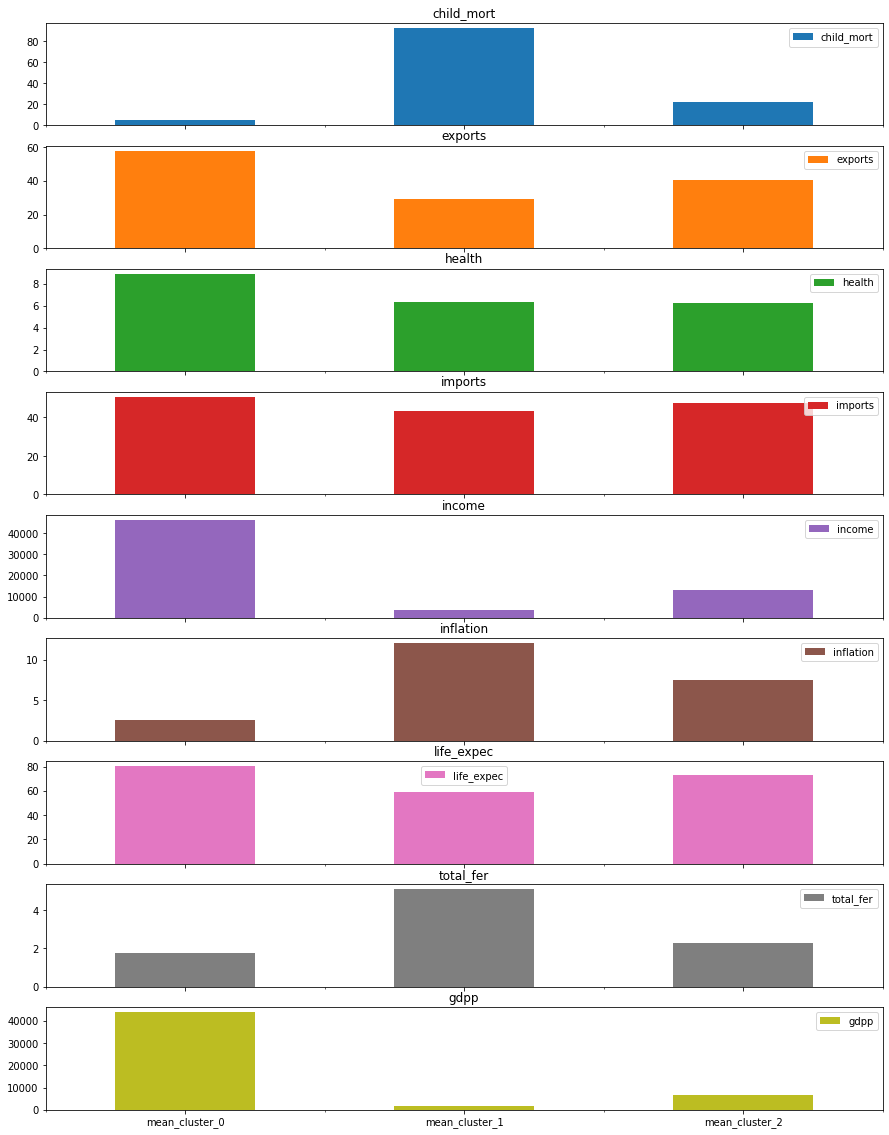

In [19]:
#KMeans - MinMax Scaled Data
cluster_characteristics(kmeans_mm_clusters);

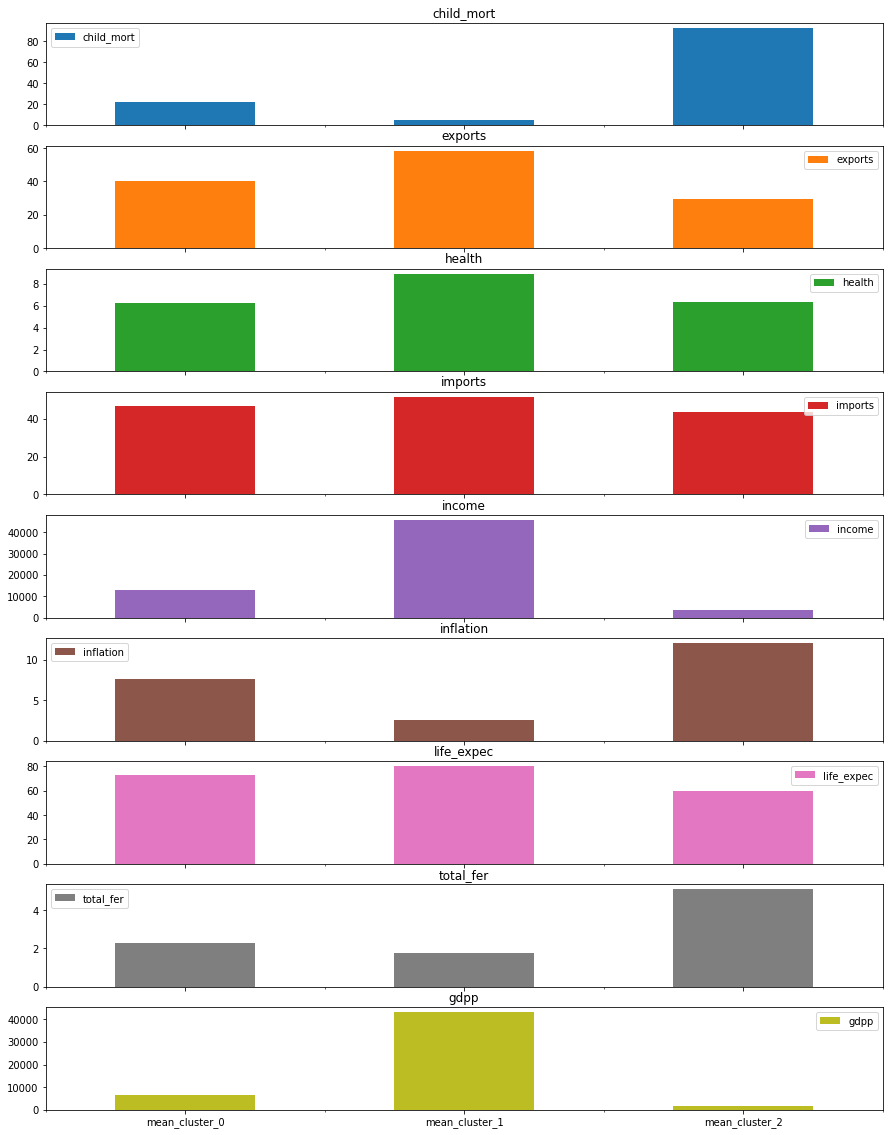

In [20]:
#KMeans - First 4 Principal Components from MinMax Scaled Data
cluster_characteristics(kmeans_mm_pc4_clusters);

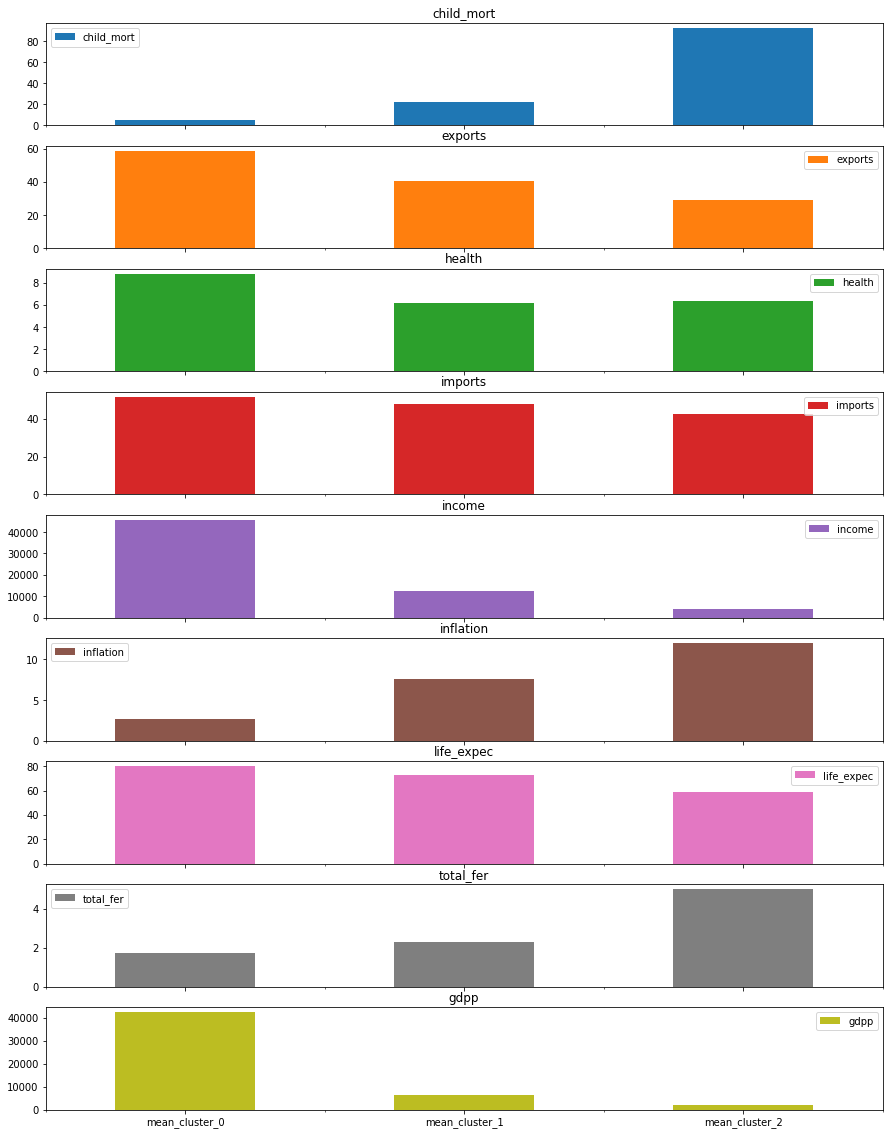

In [21]:
#KMeans - Standard Scaled Data
cluster_characteristics(kmeans_ss_clusters);

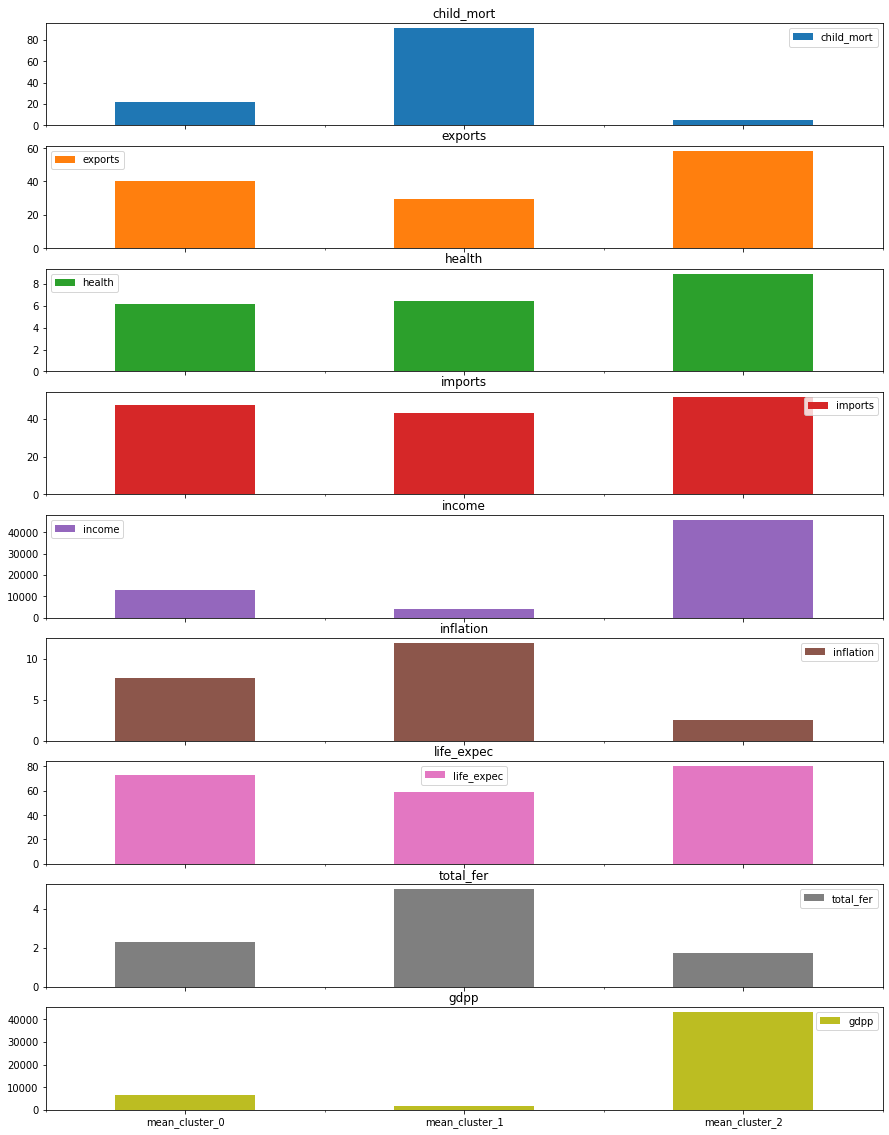

In [22]:
#KMeans - First 4 Principal Components from Standard Scaled Data
cluster_characteristics(kmeans_ss_pc4_clusters);

### Insights from KMeans
As we can see from the first KMeans graph above, the characteristics of clusters are as follows (in terms of relative rank):

In [53]:
table_data = [
    ('Child Mortality', 'low', 'high', 'middle'),
    ('Exports', 'high', 'low', 'middle'),
    ('Health', 'high', 'middle', 'low'),
    ('Imports', 'high', 'low', 'middle'),
    ('Income', 'high', 'low', 'middle'),
    ('Inflation', 'low', 'high', 'middle'),
    ('Life Expectancy', 'high', 'low', 'middle'),
    ('Total Fertility', 'low', 'high', 'middle'),
    ('GDDP', 'high', 'low', 'middle'),
    
]
table_cols = ['Factor', 'Cluster 0', 'Cluster 1', 'Cluster 2']
pd.DataFrame(table_data, columns = table_cols)

,Factor,Cluster 0,Cluster 1,Cluster 2
0,Child Mortality,low,high,middle
1,Exports,high,low,middle
2,Health,high,middle,low
3,Imports,high,low,middle
4,Income,high,low,middle
5,Inflation,low,high,middle
6,Life Expectancy,high,low,middle
7,Total Fertility,low,high,middle
8,GDDP,high,low,middle


Given the above table, we believe that Cluster 1 best represent high-need countries, Cluster 0 best represents low-need countries and Cluster 2 best represents moderate-need countries. In this case, countries in Cluster 0 are the ones in need of financial assistance. If we make use of the same logic for the clusters for PC4 MinMax and Standard Scaled data, we see that countries in need are represented by Cluster 2. The 4th graph above did not perform well (first 4 principal components of standard scaled data) and can be ignored as it was inconsistent with the other 3 datasets. For the next 2 clustering algorithms, we will simply make use of MinMax and Standard scaled datasets.

## Agglomerative Clustering

In [24]:
#We will initiate our hierachichal cluster with 3 clusters
def agg_clustering(df):
    hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

    return hierarchical_cluster.fit_predict(df)

agg_cl_mm_features_clusters = agg_clustering(mm_features_df)
agg_cl_mm_features_pc4_clusters = agg_clustering(principal_component_analysis_PC4(mm_features_df))
agg_cl_ss_features_clusters = agg_clustering(ss_features_df)

#add the above predicted labels to the main dataset
data['agg_cl_mm_cluster'] = agg_cl_mm_features_clusters
data['agg_cl_mm_pc4_cluster'] = agg_cl_mm_features_pc4_clusters
data['agg_cl_ss_cluster'] = agg_cl_ss_features_clusters

#Create datasets which reflect data belonging to clusters, of each dataset, for each clustering algorithm used
agg_cl_mm_clusters = pd.concat([data_cleaner(data.loc[data['agg_cl_mm_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['agg_cl_mm_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['agg_cl_mm_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)
agg_cl_mm_pc4_clusters = pd.concat([data_cleaner(data.loc[data['agg_cl_mm_pc4_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['agg_cl_mm_pc4_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['agg_cl_mm_pc4_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)
agg_cl_ss_clusters = pd.concat([data_cleaner(data.loc[data['agg_cl_ss_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['agg_cl_ss_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['agg_cl_ss_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)

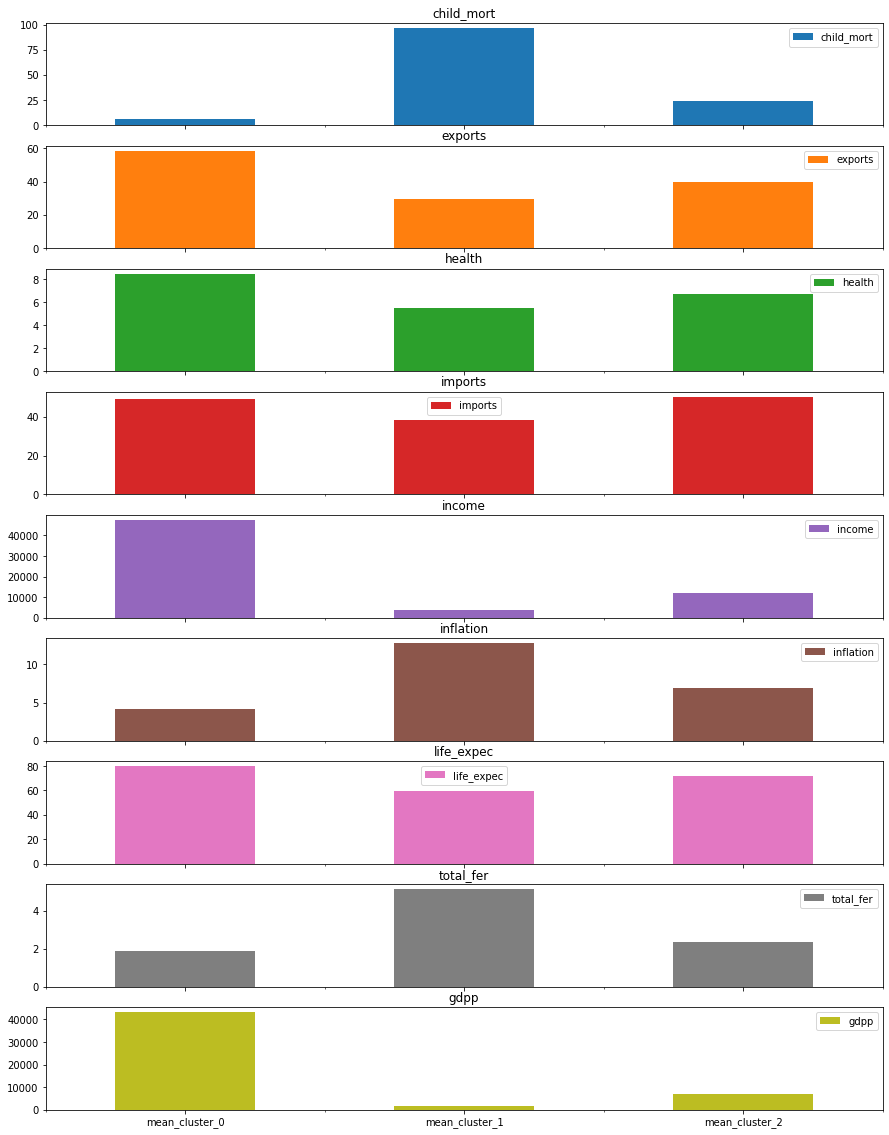

In [25]:
#Agglomerative Clustering - MinMax Scaled Data
cluster_characteristics(agg_cl_mm_clusters);

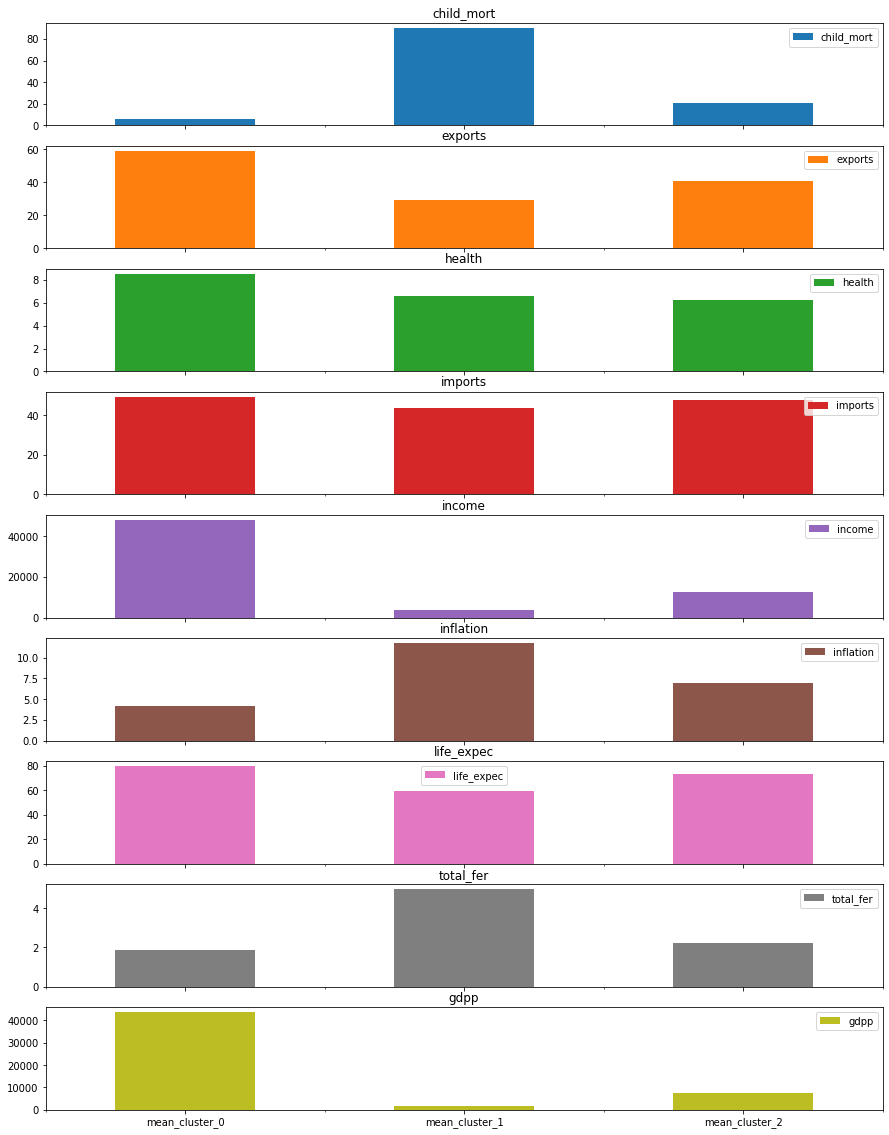

In [26]:
#Agglomerative Clustering - PC4 MinMax Scaled Data
cluster_characteristics(agg_cl_mm_pc4_clusters);

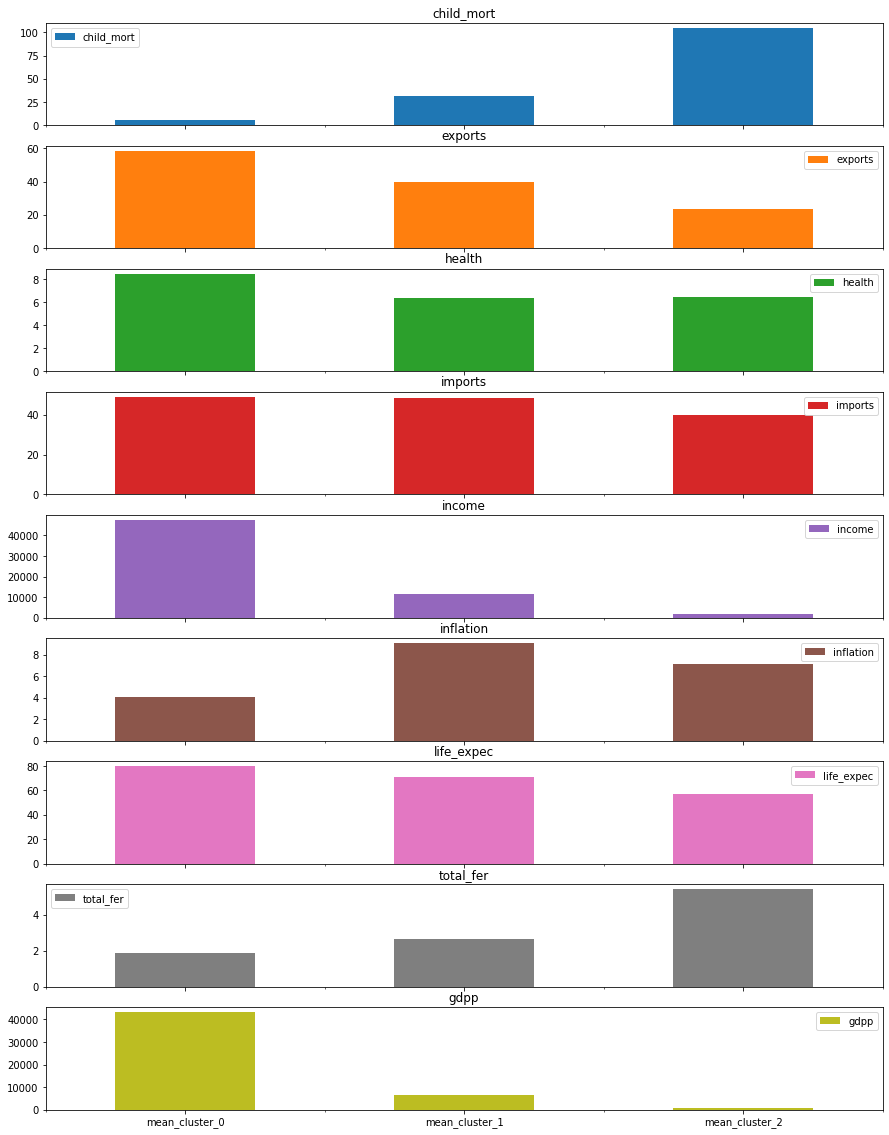

In [27]:
#Agglomerative Clustering -Standard Sclaed Scaled Data
cluster_characteristics(agg_cl_ss_clusters);

Agglomerative clustering did not perform as well across all datasets, but we can see that from the MinMax Scaled and PC4 MinMax Scaled data, Cluster 0 represents low-need countries, Cluster 1 represents high-need countries and Cluster 2 represents moderate-need countries.

### DBSCAN Clustering

In our final clustering model, we will make use of DBSCAN on the 3 datasets of interest used in the Agglomerative Clustering method.

In [33]:
#Hyperparameter optimization for DBSCAN using KNN
#We will use the MinMax and Standard Scaled Datasets to determine optimal parameters
def dbscan_parameters(df):

    knn = NearestNeighbors(n_neighbors = 7)
    model = knn.fit(df)
    distances, indices = knn.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    plt.grid()
    plt.plot(distances);
    plt.xlabel('Points Sorted by Distance')
    plt.ylabel('7-NN Distance')
    plt.title('K-Distance Graph')
    return plt.show()

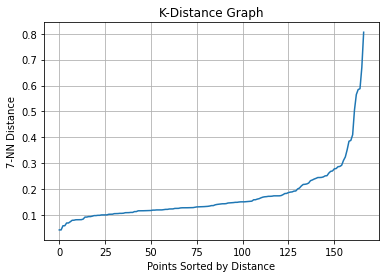

In [34]:
#Finding eps for MinMax Scaled Data
dbscan_parameters(mm_features_df) #most optimal eps value is around 0.2

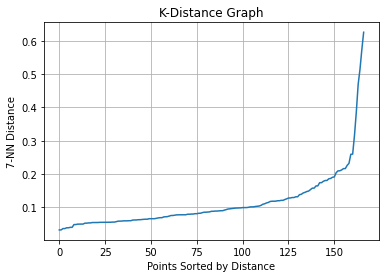

In [36]:
#Finding eps for PC4 MinMax Scaled Data
dbscan_parameters(principal_component_analysis_PC4(mm_features_df)) #most optimal eps value is around 0.2

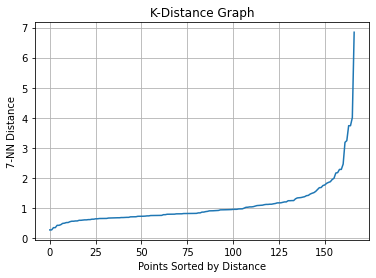

In [35]:
#Finding eps for Standard Scaled Data
dbscan_parameters(ss_features_df) #most optimal eps value is around 1.8

In [45]:
def dbscan_clustering(df, eps_n):

    db = DBSCAN(eps = eps_n, min_samples = 8).fit(df)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('Number of Clusters : ', n_clusters_)
    print('Number of Outliers : ', n_noise_)

    return labels

dbscan_mm_features_clusters = dbscan_clustering(mm_features_df, 0.2)
dbscan_mm_features_pc4_clusters = dbscan_clustering(principal_component_analysis_PC4(mm_features_df), 0.15)
dbscan_ss_features_clusters = dbscan_clustering(ss_features_df, 1.2)

#add the above predicted labels to the main dataset
data['dbscan_mm_cluster'] = dbscan_mm_features_clusters
data['dbscan_mm_pc4_cluster'] = dbscan_mm_features_pc4_clusters
data['dbscan_ss_cluster'] = dbscan_ss_features_clusters

#Create datasets which reflect data belonging to clusters, of each dataset, for each clustering algorithm used
dbscan_mm_clusters = pd.concat([data_cleaner(data.loc[data['dbscan_mm_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['dbscan_mm_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['dbscan_mm_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)
dbscan_mm_pc4_clusters = pd.concat([data_cleaner(data.loc[data['dbscan_mm_pc4_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['dbscan_mm_pc4_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['dbscan_mm_pc4_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)
dbscan_ss_clusters = pd.concat([data_cleaner(data.loc[data['dbscan_ss_cluster'] == 0]).add_suffix('_cluster_0'), data_cleaner(data.loc[data['dbscan_ss_cluster'] == 1]).add_suffix('_cluster_1'), data_cleaner(data.loc[data['dbscan_ss_cluster'] == 2]).add_suffix('_cluster_2')], axis = 1)

Number of Clusters :  3
Number of Outliers :  65
Number of Clusters :  3
Number of Outliers :  62
Number of Clusters :  3
Number of Outliers :  71


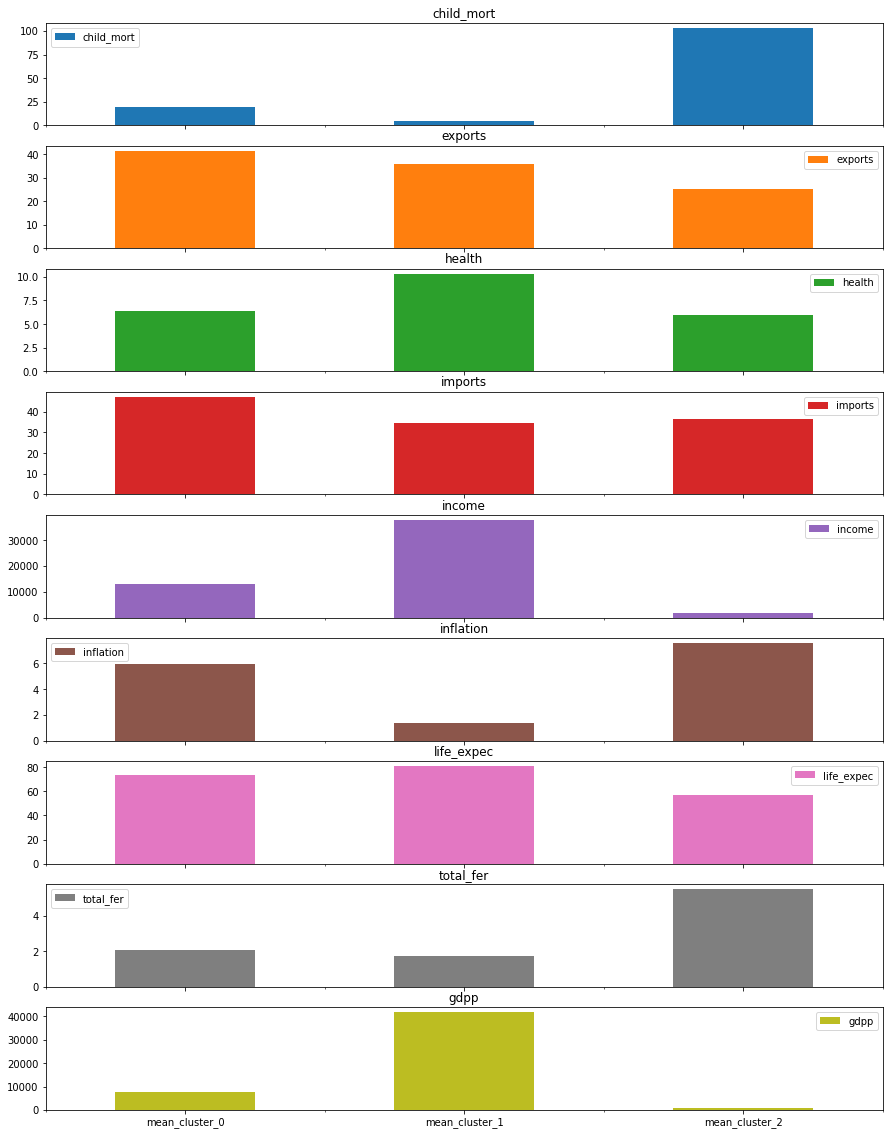

In [46]:
#DBSCAN Clustering - MinMax Sclaed Scaled Data
cluster_characteristics(dbscan_mm_clusters);

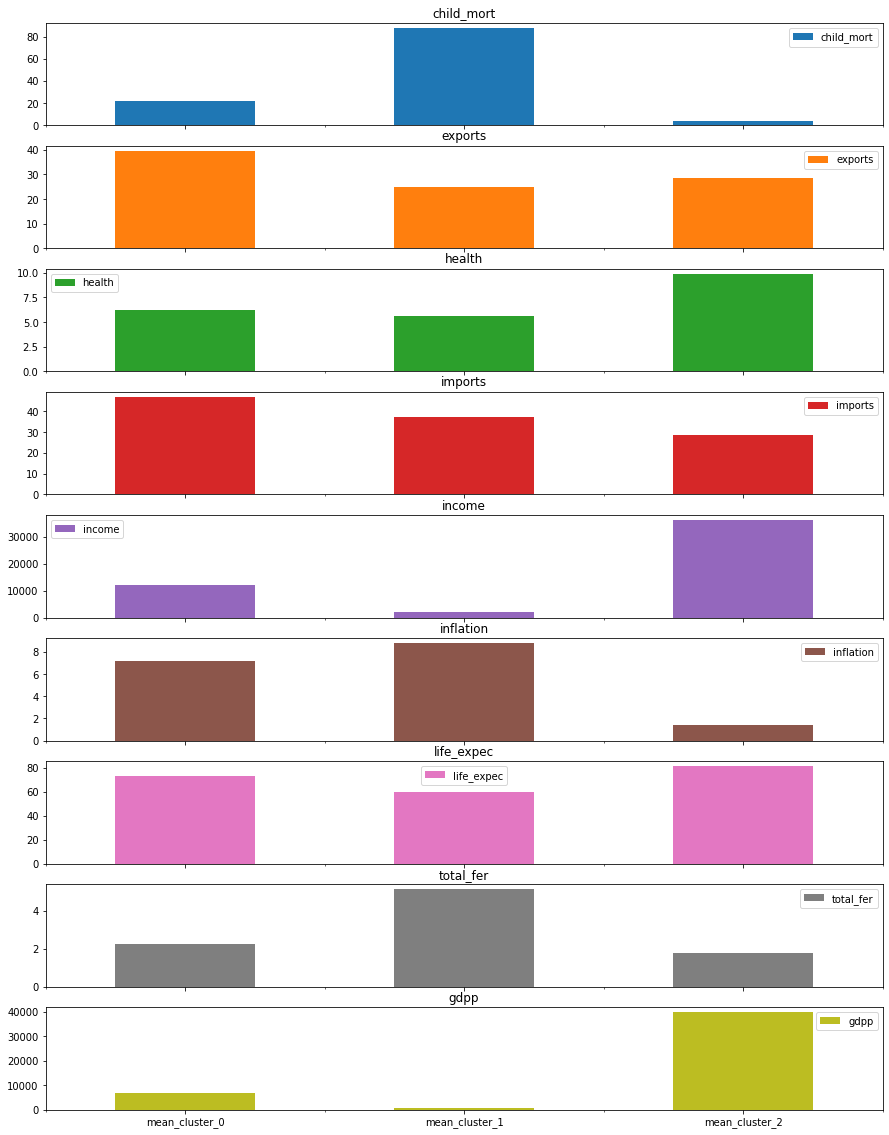

In [47]:
#DBSCAN Clustering - PC4 MinMax Sclaed Scaled Data
cluster_characteristics(dbscan_mm_pc4_clusters);

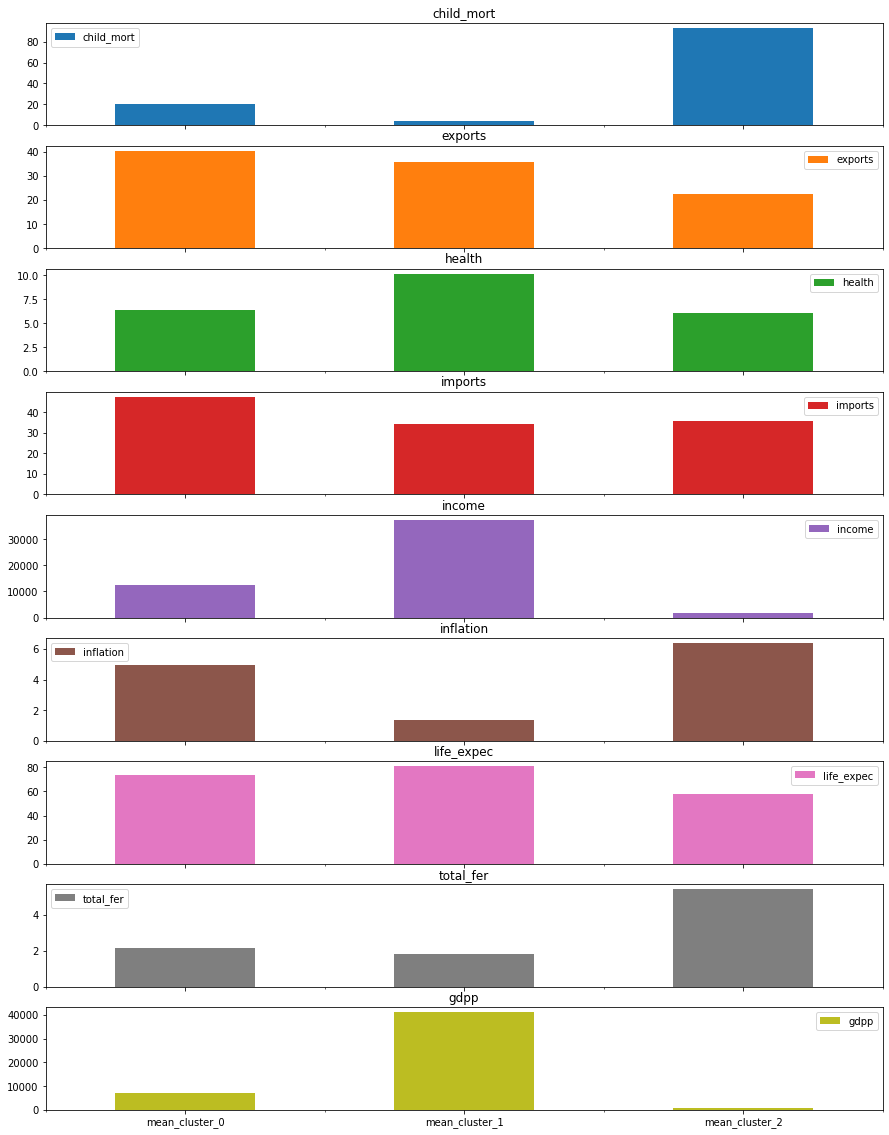

In [48]:
#DBSCAN Clustering - Standard Sclaed Scaled Data
cluster_characteristics(dbscan_ss_clusters);

From DBSCAN Clustering, we can see that for MinMax and Standard scaled data, cluster 2 represents high-need countries, and in the PC4 Min Max scaled data, performance was mixed. Using our MinMax and Standard Scaled datasets, we can define countries in need using the 3 clustering algorithms as follows:
* KMeans: 
    * MinMax: Cluster 1
    * Standard: Cluster 2
* Agglomerative Clustering:
    * MinMax: Cluster 1
    * Standard: Did not perform well
* DBSCAN:
    * MinMax: Cluster 2
    * Standard: Cluster 2

Using KMeans alone, we see that countries that can benefit from HELP International's funding are:

In [64]:
data.loc[(data['kmeans_mm_cluster'] == 1)&(data['kmeans_ss_cluster'] == 2)].country.to_numpy()

array(['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire",
       'Equatorial Guinea', 'Eritrea', 'Gabon', 'Gambia', 'Ghana',
       'Guinea', 'Guinea-Bissau', 'Haiti', 'Iraq', 'Kenya', 'Kiribati',
       'Lao', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali',
       'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria',
       'Pakistan', 'Rwanda', 'Senegal', 'Sierra Leone', 'Sudan',
       'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Yemen', 'Zambia'],
      dtype=object)

However, countries in the direst of need will meet the majority of the clustering algortihm definitions, and these include:

In [65]:
data.loc[(data['kmeans_mm_cluster'] == 1)&(data['kmeans_ss_cluster'] == 2)&(data['agg_cl_mm_cluster'] == 1)&(data['dbscan_mm_cluster'] == 2)&(data['dbscan_ss_cluster'] == 2)].country.to_numpy() 

array(['Afghanistan', 'Burkina Faso', 'Cameroon', 'Guinea-Bissau',
       'Malawi', 'Mali', 'Mozambique', 'Tanzania', 'Zambia'], dtype=object)

# Summary Insights

## Main Objective
* The primary objective is to create clusters of need using socio-economic and health related attributes of each country in order to determine countries/ regions in need of funding from the HELP International

## Data Exploration
### Dataset processing
Steps taken included:
* Finding missing values to assess completeness of data and if we needed any imputation methods to fill in missing data
    * There was no missing data

### Summary Statistics
#### Using the original dataset
* Looked into the mean, median, standard deviation, minimum, maximum and quartile distribution of the different variables of interest
* Made use of a pair plot to understand the relation among variables
* Made use of a correlation heatmap to understand the correlative relationship between variables
    * This allowed us to assess whether a PCA was necessary to remove highly correlated variables that were not adding extra information to the dataset, and potentially improve our clustering algorithms via dimensionality reduction

### Feature Engineering/ Scaling
* 2 scaling methods were used:
    * MinMax Scaling
    * Standard/ Normalization Scaling
* Conducted PCA on the above 2 datasets in order to assess which principal components explained the majority of the variance in the data
    * The first 4 principal components explained over 87% of the variance in the data, hence we created an additional 2 datasets
        * PC4 MinMax Scaled data
        * PC4 Standard Scaled data
## Models
### Models Used
* Made use of 3 clustering models
    * KMeans
    * Agglomerative Clustering
    * DBSCAN
* Using a heuristic understanding of need, we made use of 3 clusters, which classified the countries Into low-, moderate- and high- need countries, based on the performance of each countries across the socio-economic and health factors provided in the dataset. 

### Recommended Model
* The KMeans clustering algorithm performed the most consistently and will be the most recommended. However, moderate performance of the Agglomerative and DBSCAN clustering algorithms may be attributed to poor to moderate hyperparameter tuning

### Findings: Countries in Need
* Using the KMeans model, countries in need include:
    * Afghanistan, Angola, Benin, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros, Congo, Dem. Rep., Congo, Rep., Cote dIvoire, Equatorial Guinea, Eritrea, Gabon, Gambia, Ghana, Guinea, Guinea-Bissau, Haiti, Iraq, Kenya, Kiribati, Lao, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Mozambique, Namibia, Niger, Nigeria, Pakistan, Rwanda, Senegal, Sierra Leone, Sudan, Tanzania, Timor-Leste, Togo, Uganda, Yemen, Zambia
* However, countries with the greatest need will be identified by all 3 models, and these include:
    * Afghanistan, Burkina Faso, Cameroon, Guinea-Bissau, Malawi, Mali, Mozambique, Tanzania, Zambia

## Next Steps
* The heuristic definition of clusters, i.e., 3 clusters has its limitations as need can be stratified into more than 3 clusters. Hence there is need to potentially assess the utility of n clusters > 3
* Feature engineering can be improved by:
    * Create new variables that may better remove correlating variables
    * Interaction terms can be considered for some variables
* Hyperparameter optimization for all models was poor to moderate, more can be done to better optimize the performance of all 3 clustering algorithms
* Consider additional clustering algorithms such as BIRCH, Mini-Batch KMeans, Mean Shift, Spectral Clustering and Gaussian Mixture Models


### References
* HELP Internation: https://help-international.org/
* Data SOurce: https://www.kaggle.com/